# Final Exam BUS 458 — Loan Data Analysis
**Objective:** Your objective is to identify the key drivers of loan approval and recommend which lender should be prioritized for each customer to maximize total payout

### **Instructions**
- Follow the prompts in each section of this notebook.
- **Where you see a “Question,” answer it directly below in a Markdown (text) cell — not as a code comment.**
- Your **reasoning, interpretations, and insights** should be written in text cells, clearly separated from code.
- You are encouraged to add extra **code cells**, **visualizations**, or **short explanations** if they strengthen your analysis or help you justify decisions.
- Make sure your notebook runs cleanly from start to finish without errors.


**Group**: Valerie Byrd & Azah Mansour

**Contributions**:


*   Valerie: Completed preliminary checks, preprocessing, and exploratory data analysis
*   Azah: Completed model building, recommendations, and streamlit deployment



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Load Data (via Google Drive or direct upload)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/Fall 25/BUS 458/loan_data_analysis_final.csv")
display(df.head())

,User ID,applications,Reason,Granted_Loan_Amount,Requested_Loan_Amount,FICO_score,Fico_Score_group,Employment_Status,Employment_Sector,Monthly_Gross_Income,Monthly_Housing_Payment,Ever_Bankrupt_or_Foreclose,Lender,Approved,bounty
0,00007820-89cb-4c1d-9940-eb270d605a35,1,cover_an_unexpected_cost,100000,123000.0,669.0,fair,full_time,consumer_discretionary,5024.0,927,0,B,0,0
1,00012b55-514c-421e-9c76-3300abbc1134,1,credit_card_refinancing,70000,79000.0,594.0,fair,full_time,information_technology,5764.0,1177,0,B,0,0
2,000157c1-b6a3-4c86-82c7-9ec1bda3799a,1,home_improvement,10000,11000.0,596.0,fair,full_time,information_technology,4017.0,1487,0,A,0,0
3,00020400-efab-4b10-8812-2a0aaf774841,1,home_improvement,100000,120000.0,642.0,fair,part_time,energy,3129.0,904,0,A,0,0
4,0002f737-0cda-48fb-91ed-533f3d0eab05,1,major_purchase,30000,34000.0,NaN,fair,full_time,energy,NaN,1620,0,A,0,0


In [4]:
# Drop columns that have no variation or are unique
df = df.drop(columns=[
    col for col in df.columns
    if df[col].nunique() <= 1 or df[col].nunique() == len(df)
])

Understand the Data: Get a quick overview of the dataset structure and variable meanings before preprocessing.

In [5]:
# Display general information about the DataFrame (data types, non-null values)
df.info()

# Display descriptive statistics for numerical columns
display(df.describe())

# Display the count of missing values for each column
display(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Reason                      100000 non-null  object 
 1   Granted_Loan_Amount         100000 non-null  int64  
 2   Requested_Loan_Amount       100000 non-null  float64
 3   FICO_score                  85000 non-null   float64
 4   Fico_Score_group            100000 non-null  object 
 5   Employment_Status           100000 non-null  object 
 6   Employment_Sector           93593 non-null   object 
 7   Monthly_Gross_Income        85000 non-null   float64
 8   Monthly_Housing_Payment     100000 non-null  int64  
 9   Ever_Bankrupt_or_Foreclose  100000 non-null  int64  
 10  Lender                      100000 non-null  object 
 11  Approved                    100000 non-null  int64  
 12  bounty                      100000 non-null  int64  
dtypes: float64(3), 

,Granted_Loan_Amount,Requested_Loan_Amount,FICO_score,Monthly_Gross_Income,Monthly_Housing_Payment,Ever_Bankrupt_or_Foreclose,Approved,bounty
count,1.000000e+05,1.000000e+05,85000.000000,85000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,6.478465e+04,7.450309e+04,629.338153,5808.783776,1888.900720,0.022460,0.109760,26.415000
std,1.965837e+05,2.264856e+05,88.684201,2988.185274,3431.924282,0.148175,0.312592,78.385644
min,5.000000e+03,5.000000e+03,300.000000,-17702.000000,300.000000,0.000000,0.000000,0.000000
25%,2.000000e+04,2.400000e+04,572.000000,3659.000000,1231.000000,0.000000,0.000000,0.000000
50%,4.000000e+04,4.400000e+04,634.000000,5153.500000,1669.000000,0.000000,0.000000,0.000000
75%,7.000000e+04,8.400000e+04,693.000000,7612.000000,2051.000000,0.000000,0.000000,0.000000
max,2.000000e+06,2.500000e+06,850.000000,19997.000000,49500.000000,1.000000,1.000000,350.000000


,0
Reason,0
Granted_Loan_Amount,0
Requested_Loan_Amount,0
FICO_score,15000
Fico_Score_group,0
Employment_Status,0
Employment_Sector,6407
Monthly_Gross_Income,15000
Monthly_Housing_Payment,0
Ever_Bankrupt_or_Foreclose,0


## 1. Preprocessing


### 1.1 Handling Missing Values

**Question:** Why is median imputation often preferable to mean imputation for income and FICO?


**Answer:** Median imputation is usually better than mean because it isn’t thrown off by outliers, so it gives a more realistic typical number for things like income or FICO.





In [6]:
# Inspect missing values
print(df.isna().sum())


Reason                            0
Granted_Loan_Amount               0
Requested_Loan_Amount             0
FICO_score                    15000
Fico_Score_group                  0
Employment_Status                 0
Employment_Sector              6407
Monthly_Gross_Income          15000
Monthly_Housing_Payment           0
Ever_Bankrupt_or_Foreclose        0
Lender                            0
Approved                          0
bounty                            0
dtype: int64


In [7]:
# Apply imputation as instructed in the instructions pdf (create copies so original rows can be restored if needed)

df_copy = df.copy()

# Imputation Policy: FICO_score → median, Monthly_Gross_Income → median, Employment_Sector → 'Unknown'

df_copy['FICO_score'] = df_copy['FICO_score'].fillna(df_copy['FICO_score'].median())
df_copy['Monthly_Gross_Income'] = df_copy['Monthly_Gross_Income'].fillna(df_copy['Monthly_Gross_Income'].median())
df_copy['Employment_Sector'] = df_copy['Employment_Sector'].fillna('Unknown')


In [8]:
# Check missing values
print(df_copy.isna().sum())

Reason                        0
Granted_Loan_Amount           0
Requested_Loan_Amount         0
FICO_score                    0
Fico_Score_group              0
Employment_Status             0
Employment_Sector             0
Monthly_Gross_Income          0
Monthly_Housing_Payment       0
Ever_Bankrupt_or_Foreclose    0
Lender                        0
Approved                      0
bounty                        0
dtype: int64


After applying the imputation policy, there are no more missing values.

### 1.2 Outliers Detection and Removal

**Question:**
Which features had the most outliers, and what impact could they have on the model?

**Answer** : There are outliers in the granted loan amount, requested loan amount, and monthly housing payment. This makes sense because most people will have similar needs, but there will be some poeple with significantly more money. We should remove those outliers because they don't align with the majority and would throw off the models.

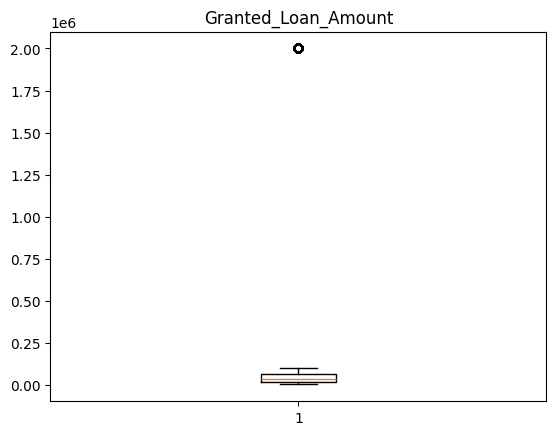

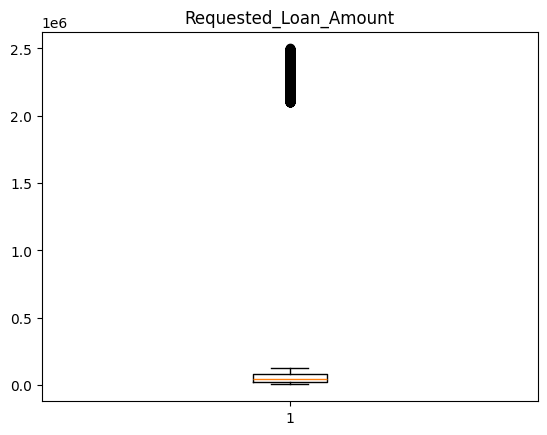

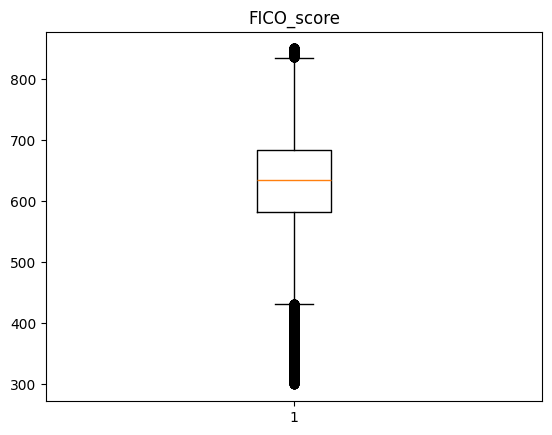

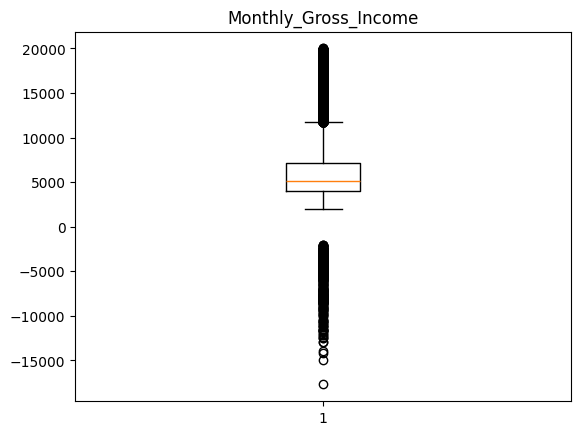

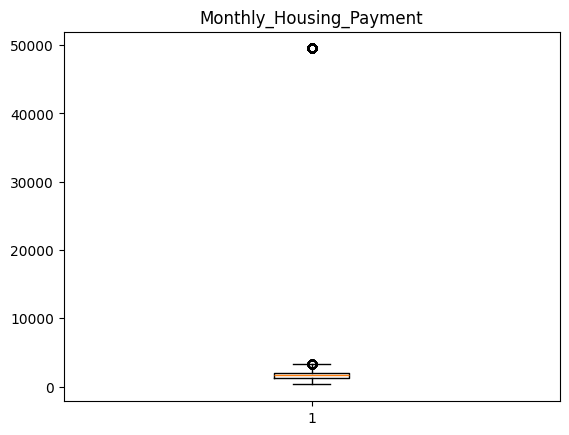

In [9]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

numeric_cols = ['Granted_Loan_Amount', 'Requested_Loan_Amount', 'FICO_score', 'Monthly_Gross_Income', 'Monthly_Housing_Payment']

# Boxplots to highlight outliers for numerical columns
for col in numeric_cols:
    plt.boxplot(df_copy[col])
    plt.title(col)
    plt.show()


In [10]:
# Remove Outliers using Z-score

from scipy import stats
import numpy as np

# Compute Z-scores for only numeric columns
z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy='omit'))

# Choose threshold
threshold = 3  # common choice: 3 standard deviations

# Identify rows to keep (all Z-scores <= threshold)
rows_to_keep = (z_scores < threshold).all(axis=1)

# Track counts before/after
before_count = df.shape[0]
df_clean = df_copy[rows_to_keep].copy()
after_count = df_clean.shape[0]

print(f"Outlier removal complete:")
print(f"Rows before: {before_count}")
print(f"Rows after:  {after_count}")
print(f"Rows removed: {before_count - after_count}")



Outlier removal complete:
Rows before: 100000
Rows after:  69831
Rows removed: 30169


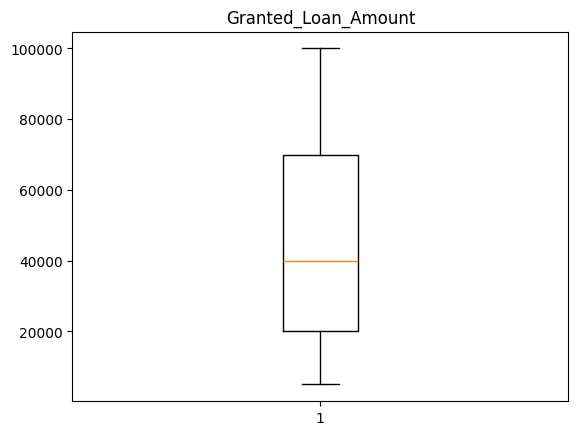

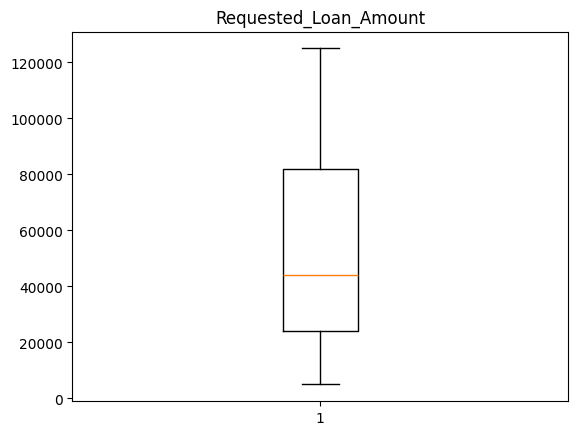

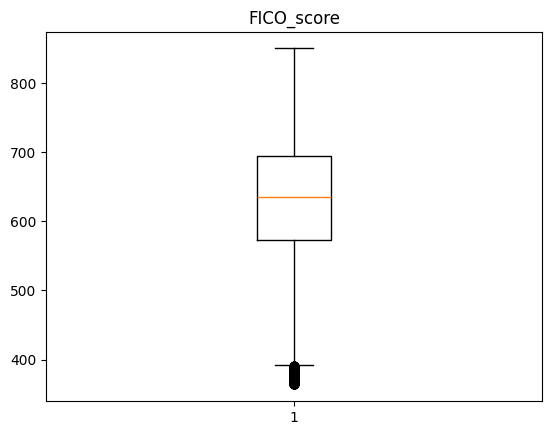

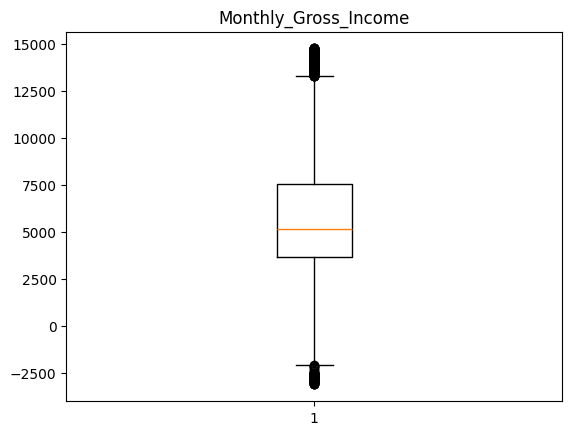

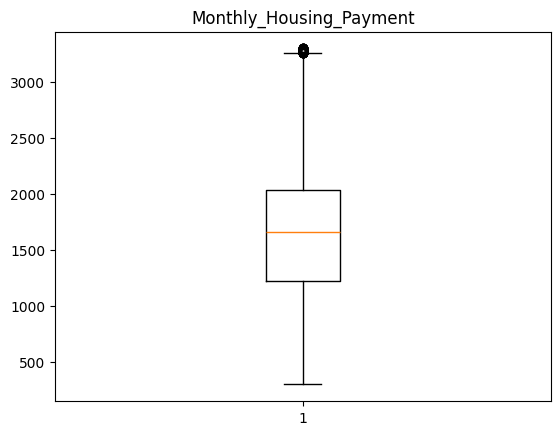

In [11]:
# BoxPlots after outlier removal
for col in numeric_cols:
    plt.boxplot(df_clean[col])
    plt.title(col)
    plt.show()

**Question:**
Why do we need to remove or treat outliers? Provide reasoning based on model performance or data integrity.

**Answer** : We need to remove or treat outliers because they can mess up our models and give misleading results, making predictions less accurate.

**Question:**
Is there a difference between boxplots before and after outlier removal?

**Answer** : Yes. After outlier removal, the boxplots look “tighter,” with the whiskers closer to the main data and no extreme points sticking out, showing a cleaner range of values.

### 1.3 Redundancy & Correlation Check (5 Marks)

Detect duplicate data and multicollinearity.

**Question:**
Which numerical variables appear most strongly correlated with each other?

**Answer:** Granted_Loan_Amount and Requested_Loan_Amount are the most strongly correlated numerical variables, meaning they tend to increase and decrease together.



**Question:**
Which numerical and categorical are strongly corelated to each other?

**Answer:** FICO_score and FICO_score_group (η² = 0.708)


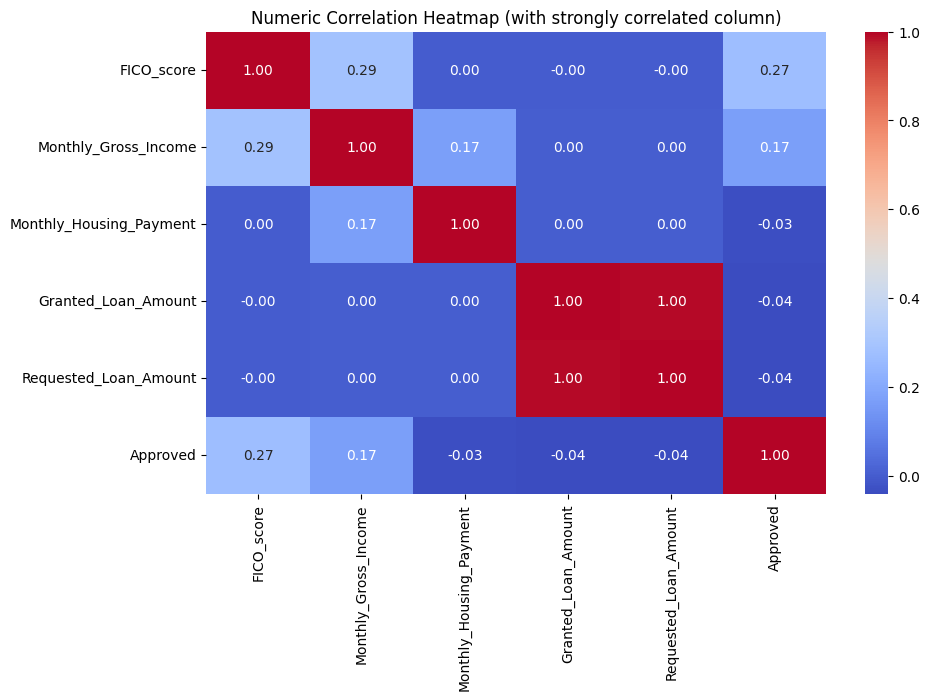

In [12]:
# Correlation between numerical features
numeric_cols = ['FICO_score', 'Monthly_Gross_Income', 'Monthly_Housing_Payment', 'Granted_Loan_Amount','Requested_Loan_Amount', 'Approved']

# Plot correlation matrix, identify highly correlated pairs automatically (|corr|>0.95, excluding self-correlation)
corr = df_clean[numeric_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Numeric Correlation Heatmap (with strongly correlated column)")
plt.show()


Top 10 Numeric-Categorical Correlation Ratios (η²):
FICO_score - Fico_Score_group: η² = 0.708 (η = 0.841)
Monthly_Gross_Income - Employment_Status: η² = 0.202 (η = 0.450)
Monthly_Gross_Income - Fico_Score_group: η² = 0.076 (η = 0.275)
Monthly_Gross_Income - Employment_Sector: η² = 0.060 (η = 0.244)
Ever_Bankrupt_or_Foreclose - Employment_Status: η² = 0.030 (η = 0.172)
Ever_Bankrupt_or_Foreclose - Employment_Sector: η² = 0.025 (η = 0.160)
Monthly_Gross_Income - Lender: η² = 0.006 (η = 0.077)
Ever_Bankrupt_or_Foreclose - Lender: η² = 0.005 (η = 0.071)
FICO_score - Employment_Sector: η² = 0.003 (η = 0.054)
Monthly_Housing_Payment - Employment_Status: η² = 0.001 (η = 0.038)


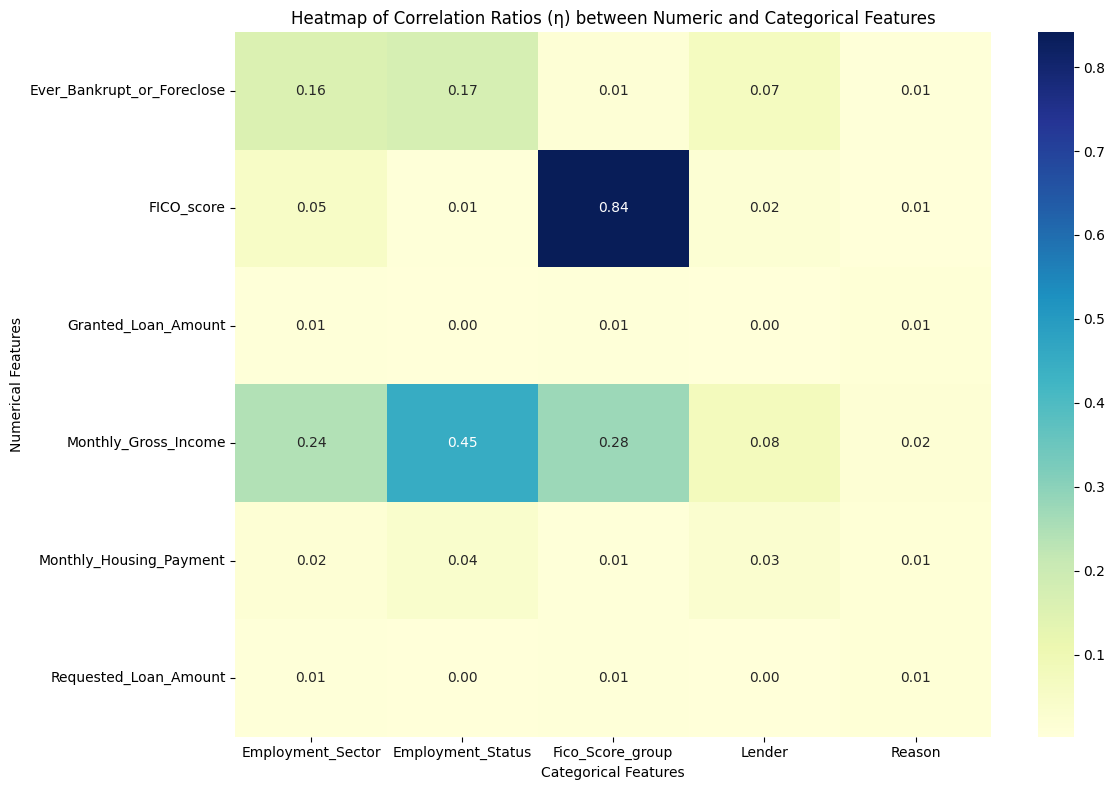

In [13]:
# Correlation between Numeric and Categorical Variables (Correlation Ratio / η²)
from scipy import stats

df_clean = df_copy.copy()

def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    cat_levels = np.unique(categories)
    overall_mean = np.mean(values)
    numerator = sum(len(values[categories == cat]) *
                    (np.mean(values[categories == cat]) - overall_mean) ** 2
                    for cat in cat_levels)
    denominator = sum((values - overall_mean) ** 2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

# test all numeric–categorical pairs
num_cat_results = []


# Identify categorical and numerical columns
categorical_cols_clean = df_clean.select_dtypes(include='object').columns.tolist()
numeric_cols_clean = df_clean.select_dtypes(include=np.number).columns.tolist()


numeric_cols_for_eta = [col for col in numeric_cols_clean if col not in ['bounty', 'Approved', ]]
categorical_cols_for_eta = [col for col in categorical_cols_clean]


for num_col in numeric_cols_for_eta:
    for cat_col in categorical_cols_for_eta:
        eta = correlation_ratio(df_clean[cat_col], df_clean[num_col])
        num_cat_results.append((num_col, cat_col, eta))

num_cat_results = sorted(num_cat_results, key=lambda x: x[2], reverse=True)
print("Top 10 Numeric-Categorical Correlation Ratios (η²):")
for num_col, cat_col, eta in num_cat_results[:10]:
    print(f"{num_col} - {cat_col}: η² = {eta**2:.3f} (η = {eta:.3f})")


# Reorganize the correlation ratio results into a pivot table/matrix for heatmap
eta_matrix = pd.DataFrame(num_cat_results, columns=['Numerical_Feature', 'Categorical_Feature', 'Eta'])
eta_pivot = eta_matrix.pivot(index='Numerical_Feature', columns='Categorical_Feature', values='Eta')

# Plot the heatmap of correlation ratios (Eta)
plt.figure(figsize=(12, 8))
sns.heatmap(eta_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Correlation Ratios (η) between Numeric and Categorical Features")
plt.xlabel("Categorical Features")
plt.ylabel("Numerical Features")
plt.tight_layout()
plt.show()



**Questions:** What features will you consider dropping after analyzing the graphs above?

**Answer** : Requested_Loan_Amount and FICO_score_group, because Requested_Loan_Amount is highly correlated with Granted_Loan_Amount, and FICO_score_group is redundant with FICO_score.



> *Note: For Decision Tree models, you do not need to remove or adjust for collinearity. The algorithm can naturally handle correlated features through its splitting mechanism. However, for Logistic Regression, multicollinearity can distort coefficient estimates and make interpretations unreliable. In that case, you may consider removing one variable from highly correlated pairs.


## 2. Exploratory Data Analysis

### 2.1 Target Variable Distribution

Analyze the distribution of the target variable (Approved) to understand class balance in loan approval outcomes.


**Question:**
Is the dataset balanced or imbalanced? Briefly explain the implication for modeling.


**Answer:**
The dataset is imbalanced because one class (Denied) has more rows than the other. Models trained on this data could become biased toward predicting denials (0) because that’s the majority class.

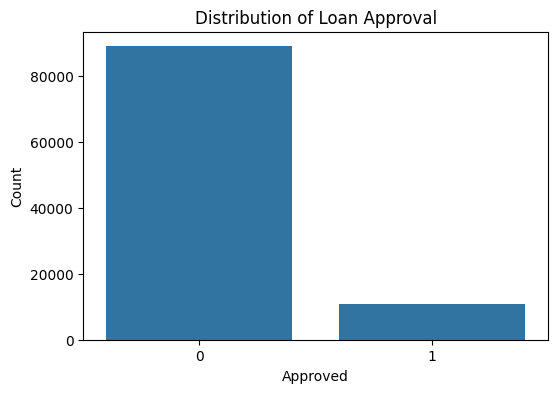

Counts:
 Approved
0    89024
1    10976
Name: count, dtype: int64

Percentages:
 Approved
0    89.02
1    10.98
Name: proportion, dtype: float64


In [14]:
# Plot 'Approved' to visualise the count and balance
plt.figure(figsize=(6,4))
sns.countplot(x='Approved', data=df_clean)
plt.title('Distribution of Loan Approval')
plt.xlabel('Approved')
plt.ylabel('Count')
plt.show()

# Counts and percentages
counts = df_clean['Approved'].value_counts()
percentages = df_clean['Approved'].value_counts(normalize=True) * 100
print("Counts:\n", counts)
print("\nPercentages:\n", percentages.round(2))

### 2.2 Distribution of Numerical Variables by Approval

Explore how key numerical variables differ between approved and rejected loan applications.


**Question:**
Which numerical variable is the most helpful variable ( most crucial predictor) ?

**Answer:**
FICO_score is the most crucial predictor because its values differ the most between approved and denied loans.


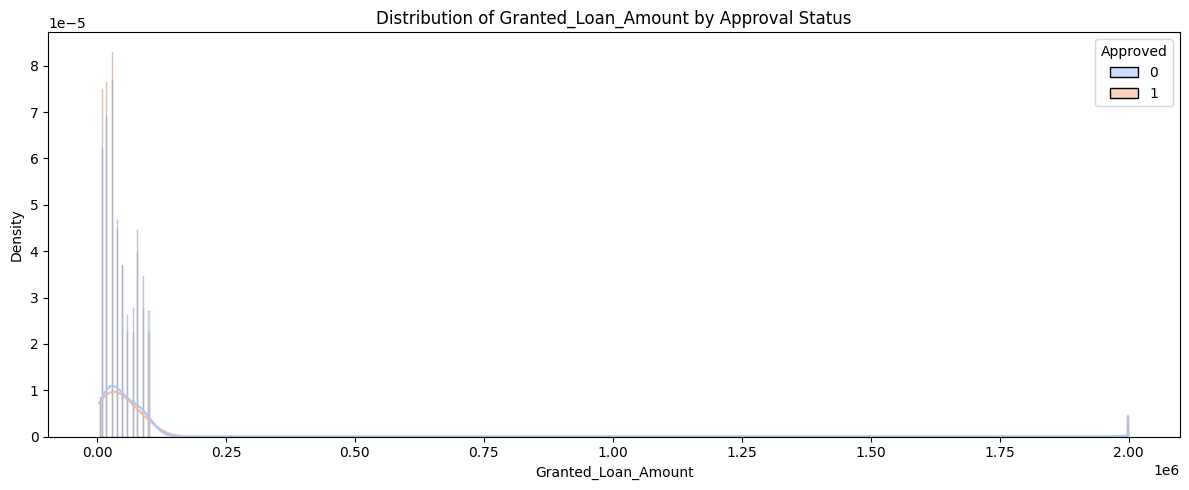

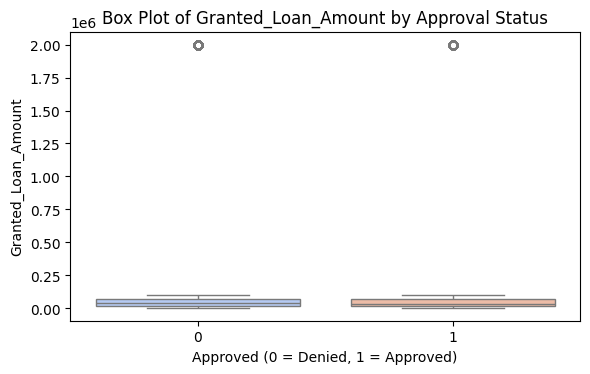

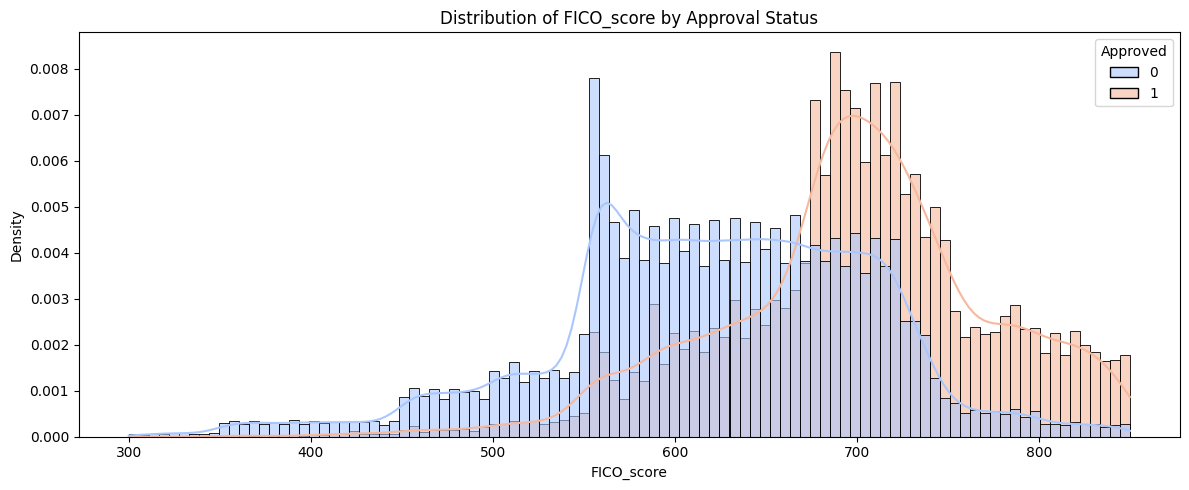

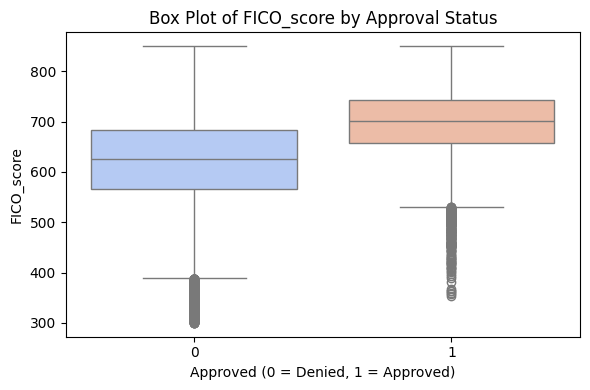

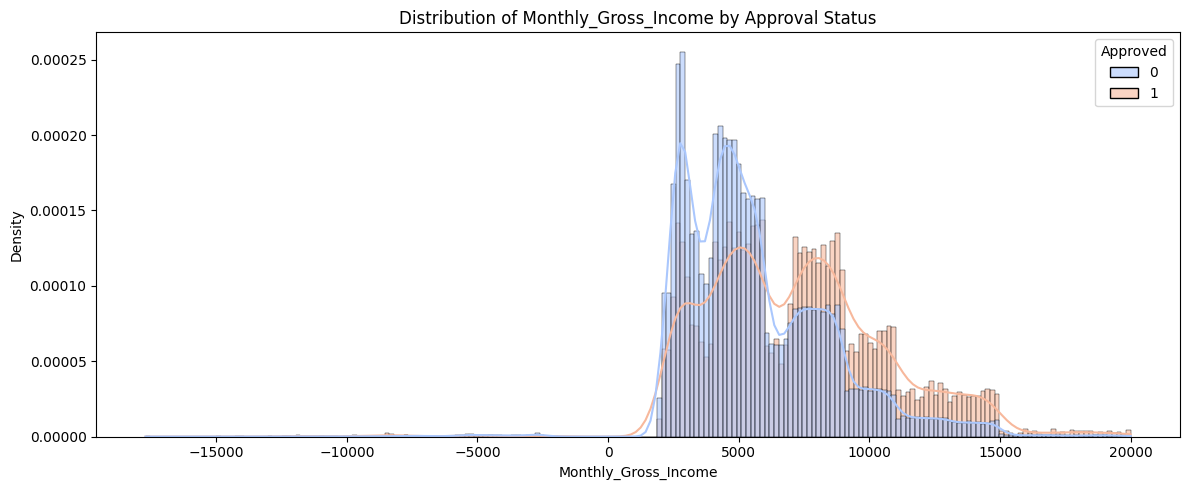

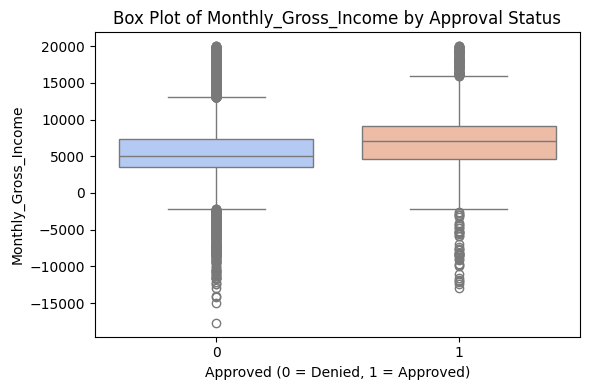

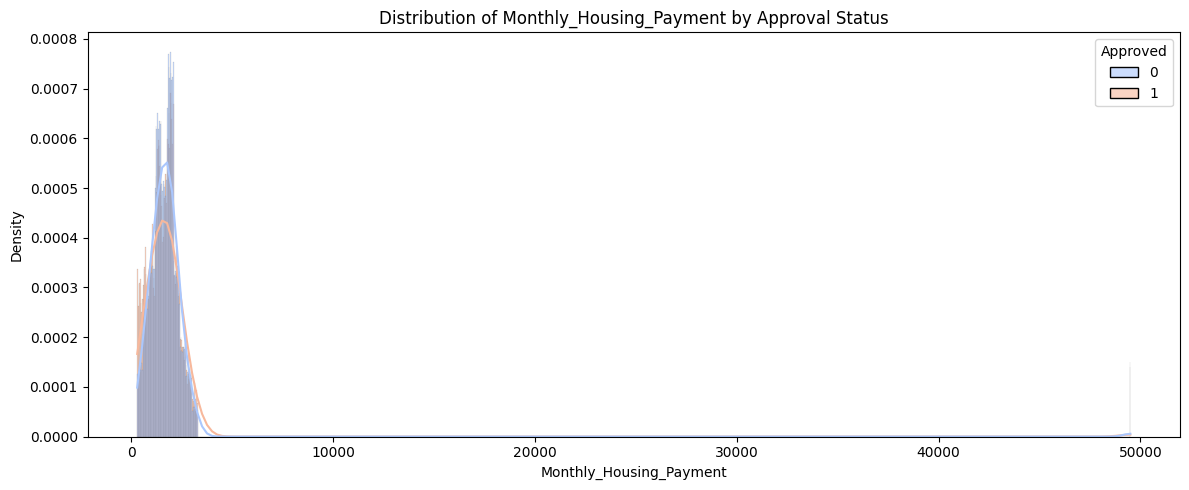

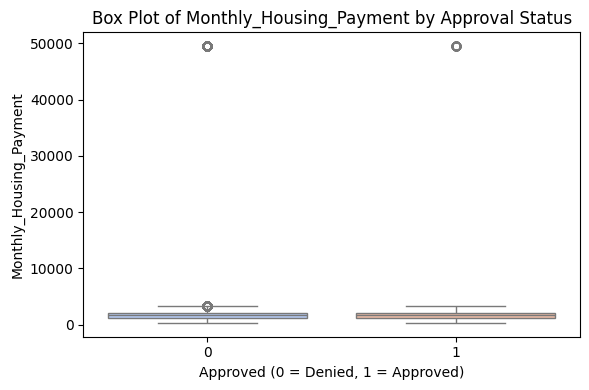

In [15]:
# Visualise numerical variables against target variable

numerical_cols = ['Granted_Loan_Amount', 'FICO_score', 'Monthly_Gross_Income', 'Monthly_Housing_Payment']

for col in numerical_cols:
    plt.figure(figsize=(12,5))
    sns.histplot(
        data=df,
        x=col,
        hue='Approved',
        kde=True,
        stat='density',
        common_norm=False,
        palette='coolwarm',
        alpha=0.6
    )
    plt.title(f'Distribution of {col} by Approval Status')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=df,
        x='Approved',
        y=col,
        hue='Approved',
        palette='coolwarm',
        legend=False
    )
    plt.title(f'Box Plot of {col} by Approval Status')
    plt.xlabel('Approved (0 = Denied, 1 = Approved)')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


### 2.3 Categorical Variables and Approval

Analyze how categorical variables (such as Employment_Sector, Loan_Purpose, or Residence_Type) relate to the loan approval outcome.


**Question:**
Which categorical variable appears to have the strongest relationship with loan approval, and how can you tell?

**Answer:**
Fico_Score_group appears to have the strongest relationship with loan approval because the approval rates vary widely across groups, from 2.78% for “poor” to 45.80% for “excellent,” showing a clear trend.


**Question:**
Are there any categories (e.g., Reason, Employment_Status) that appear to have minimal predictive value? Justify your answer with approval rate differences.

**Answer:**
The Reason variable appears to have minimal predictive value because approval rates are very similar across all categories, ranging only from 10.81% to 11.27%, so it doesn’t help distinguish approved from denied loans.

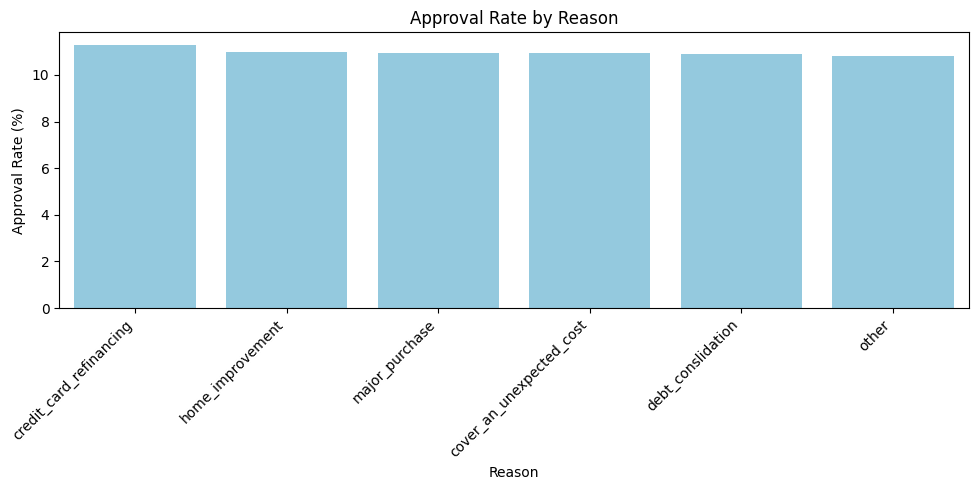


Approval Rate by Reason:
Reason
credit_card_refinancing     11.27
home_improvement            10.98
major_purchase              10.95
cover_an_unexpected_cost    10.93
debt_conslidation           10.89
other                       10.81
Name: Approved, dtype: float64


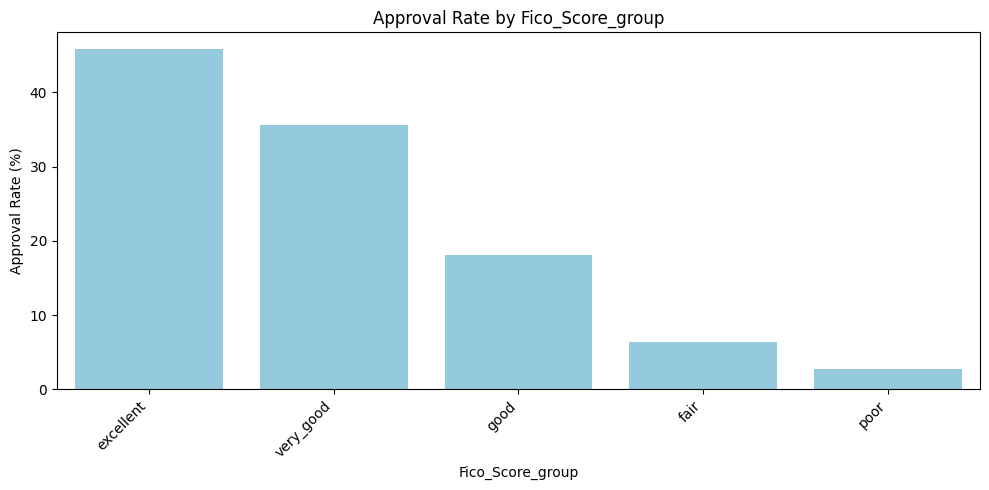


Approval Rate by Fico_Score_group:
Fico_Score_group
excellent    45.80
very_good    35.65
good         18.06
fair          6.44
poor          2.78
Name: Approved, dtype: float64


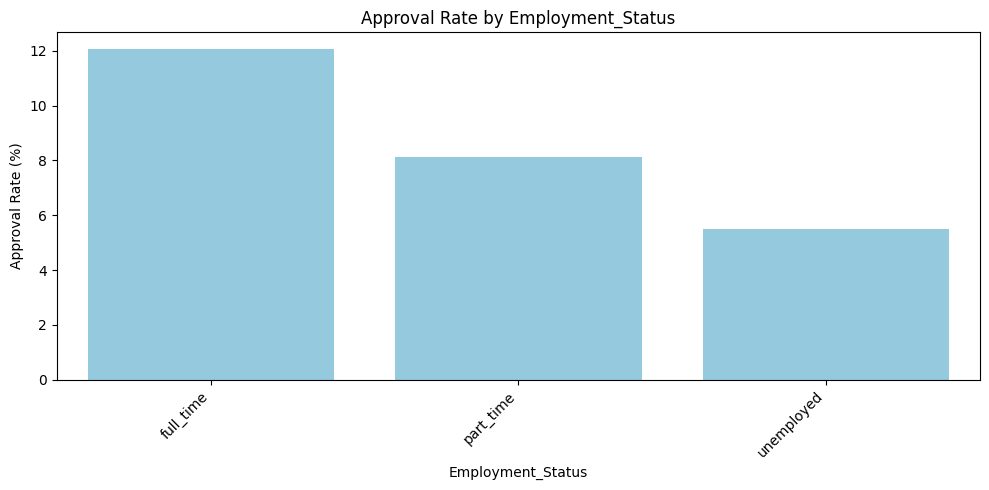


Approval Rate by Employment_Status:
Employment_Status
full_time     12.07
part_time      8.12
unemployed     5.49
Name: Approved, dtype: float64


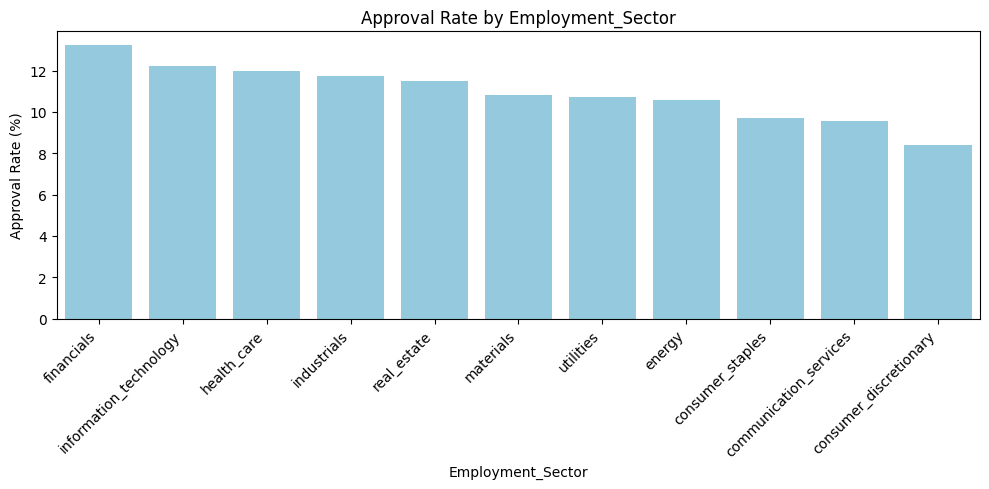


Approval Rate by Employment_Sector:
Employment_Sector
financials                13.24
information_technology    12.20
health_care               11.97
industrials               11.75
real_estate               11.50
materials                 10.83
utilities                 10.71
energy                    10.60
consumer_staples           9.68
communication_services     9.57
consumer_discretionary     8.42
Name: Approved, dtype: float64


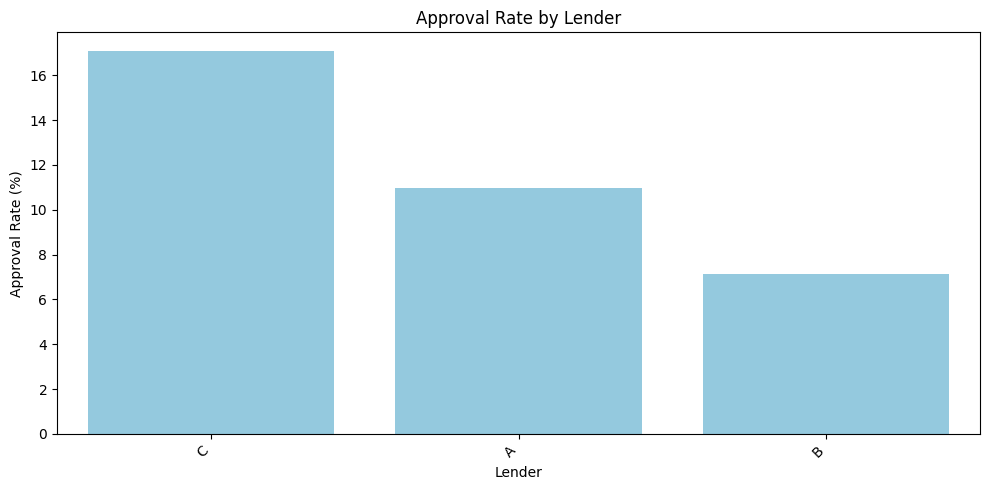


Approval Rate by Lender:
Lender
C    17.06
A    10.97
B     7.13
Name: Approved, dtype: float64


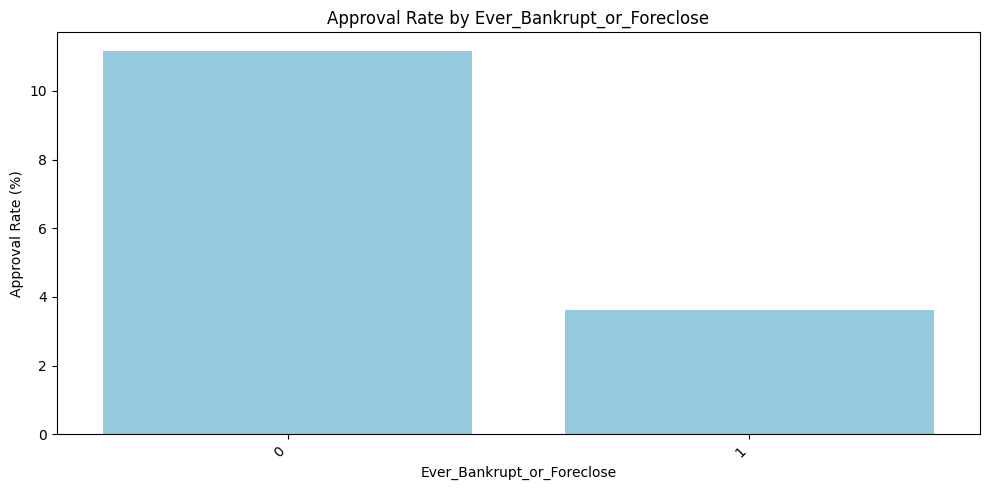


Approval Rate by Ever_Bankrupt_or_Foreclose:
Ever_Bankrupt_or_Foreclose
0    11.15
1     3.61
Name: Approved, dtype: float64


In [16]:
# Visualise categorical variables against target variable

categorical_cols = [
    'Reason', 'Fico_Score_group', 'Employment_Status',
    'Employment_Sector', 'Lender', 'Ever_Bankrupt_or_Foreclose'
]

for col in categorical_cols:
    approval_rates = df.groupby(col)['Approved'].mean().sort_values(ascending=False) * 100

    plt.figure(figsize=(10,5))
    sns.barplot(x=approval_rates.index, y=approval_rates.values, color='skyblue')
    plt.title(f'Approval Rate by {col}')
    plt.xlabel(col)
    plt.ylabel('Approval Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"\nApproval Rate by {col}:\n{approval_rates.round(2)}")


### Cross Feature plots for multi-dimensional analysis.

####Grouped Bar Chart Showing Approval Rate by Reason and FICO Score Group

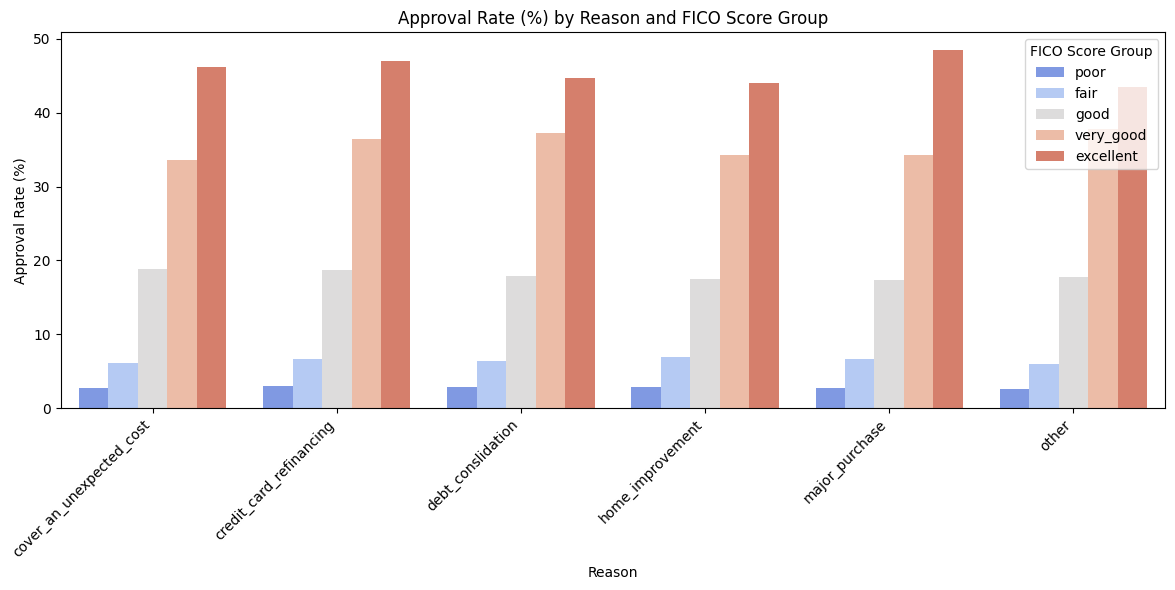

In [17]:
# Calculate approval rates
approval_rates = df_clean.groupby(['Reason', 'Fico_Score_group'])['Approved'].mean().reset_index()
approval_rates['Approved'] = approval_rates['Approved'] * 100  # convert to %

# Define FICO Score Group order
fico_order = ['poor', 'fair', 'good', 'very_good', 'excellent']

# Plot grouped bar chart
# Plot grouped bar chart with correct order
plt.figure(figsize=(12,6))
sns.barplot(
    data=approval_rates,
    x='Reason',
    y='Approved',
    hue='Fico_Score_group',
    hue_order=fico_order,
    palette='coolwarm'
)
plt.title('Approval Rate (%) by Reason and FICO Score Group')
plt.ylabel('Approval Rate (%)')
plt.xlabel('Reason')
plt.xticks(rotation=45, ha='right')
plt.legend(title='FICO Score Group')
plt.tight_layout()
plt.show()

Interpretation: The group bar chart shows that approval rates rise with FICO Score Group across all reasons, but Reason itself does not strongly affect approval since rates are similar within each group.

#### Heatmap showing Approval rate by Employment_Sector and Income Level

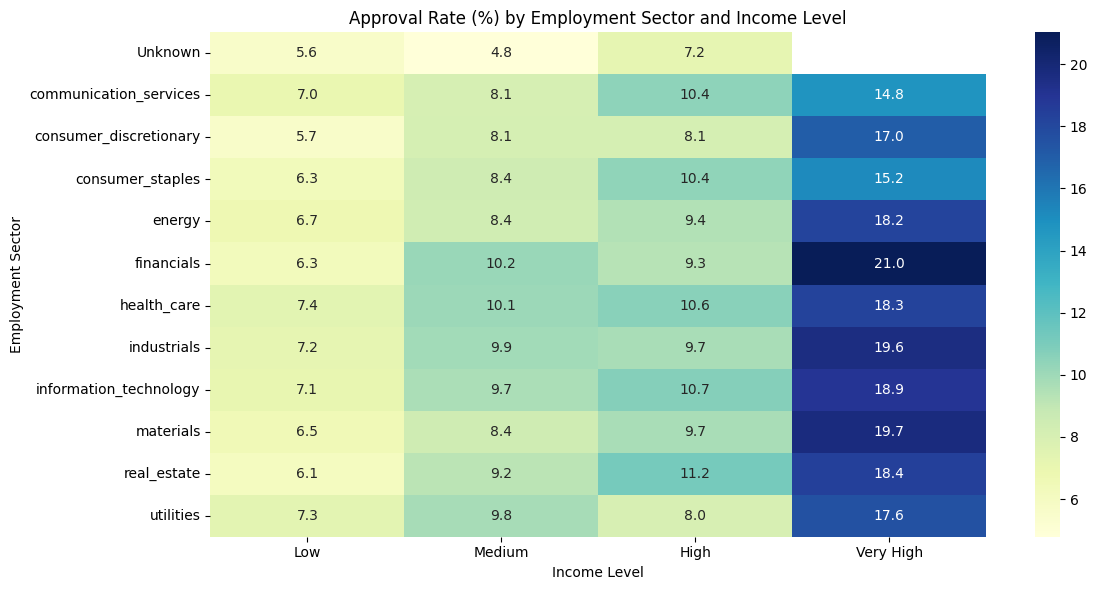

In [18]:
# Create income bins (quartiles)
df_clean['Income_Bin'] = pd.qcut(df_clean['Monthly_Gross_Income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Pivot table: rows = Employment_Sector, columns = Income_Bin, values = mean approval rate
cross_tab = df_clean.pivot_table(
    index='Employment_Sector',
    columns='Income_Bin',
    values='Approved',
    aggfunc='mean',
    observed=False
) * 100  # convert to percentages

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(cross_tab, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Approval Rate (%) by Employment Sector and Income Level')
plt.xlabel('Income Level')
plt.ylabel('Employment Sector')
plt.tight_layout()
plt.show()

Interpretation: Approval rates generally increase with income across all employment sectors, with higher-income individuals in sectors like financials and materials having the highest approval rates.

## 3.5 Business Insights from EDA

After completing your visualizations and cross-feature analyses, summarize your findings in the context of loan approval and lender matching.  
Use this section to connect data patterns to real-world meaning before building predictive models.


**Question:** Which variables are the most helpful in understanding if a customer is going to be approved or denied for a loan?  

> **Answer**: FICO_score is the strongest predictor of approval, as higher scores consistently correspond to higher approval rates. Other helpful variables include Monthly_Gross_Income and Monthly_Housing_Payment, while categorical features like FICO_Score_group and Employment_Sector also show meaningful differences in approval likelihood.

**Question:** Are there any feature modifications or transformations that would improve the predictive power of a variable?  

> **Answer**: Binning continuous variables like Monthly_Gross_Income into categories (low, medium, high, very high) or grouping FICO scores into categories helps capture nonlinear patterns.

**Question:** What is each lender’s average approval rate?  

> **Answer**: Based on the dataset, Lender C has the highest average approval rate (17.06%), followed by Lender A (10.97%), and Lender B has the lowest (7.13%).

**Question:** Are there any clear differences between the three lenders in terms of which types of customers they approve?  

> **Answer**: Yes. Lender C tends to approve a larger proportion of customers across all FICO scores and income levels, while Lender B is more selective. High FICO scores and higher income customers are more likely to be approved by all lenders, but the degree of selectivity differs.

**Question:** Are there variables that reliably predict a customer’s approval likelihood for a particular lender?  

> **Answer**: FICO_score and FICO_Score_group reliably predict approval for all lenders, but the importance of other variables like Monthly_Gross_Income or Employment_Sector varies by lender. Lender C approves more broadly, while Lender B is more selective, so certain features are more predictive for Lender B than for C.



  > Note: Treat this section as your interpretation bridge between EDA and modeling. The goal is to show that you understand *why* certain patterns exist, not just that they exist.


## 3. Model Training

### 3.1 Train/Test Split and Encoding

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# rename dataframe to df_model
df_model = df_clean.copy()

# We have to drop target variable and corelated variables
X = df_model.drop(columns=['Approved', 'bounty','Granted_Loan_Amount'])
y = df_model['Approved']


# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical features
X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)

#Scale numeric features
numerical_cols_to_scale = [
    'FICO_score',
    'Monthly_Gross_Income',
    'Monthly_Housing_Payment','Requested_Loan_Amount']

scaler = StandardScaler()
X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])




### 3.2 Logistic Regression Model
Build and interpret a Logistic Regression model to predict the likelihood of loan approval (Approved = 1).

**Question**
How accurate is the model on the test data, and what does this imply about its predictive strength?

**Answer**
Our model has a 72.70% accuracy rate, indicating that it performs reasonably well at correctly predicting approved and denied loans about 73% of the time.

In [80]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
logmodel = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
logmodel.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_score, recall_score, auc, f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluate the model
# Predict labels for train and test
y_train_log = logmodel.predict(X_train)
y_test_log = logmodel.predict(X_test)


# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_log))
print("Test Accuracy:", accuracy_score(y_test, y_test_log))

# ROC-AUC
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_log))

# Full Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_log, zero_division=0))


Train Accuracy: 0.71675
Test Accuracy: 0.72715
Test ROC-AUC: 0.71738988239043

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     17821
           1       0.24      0.70      0.36      2179

    accuracy                           0.73     20000
   macro avg       0.60      0.72      0.59     20000
weighted avg       0.88      0.73      0.78     20000




Confusion Matrix:
[[13007  4814]
 [  643  1536]]


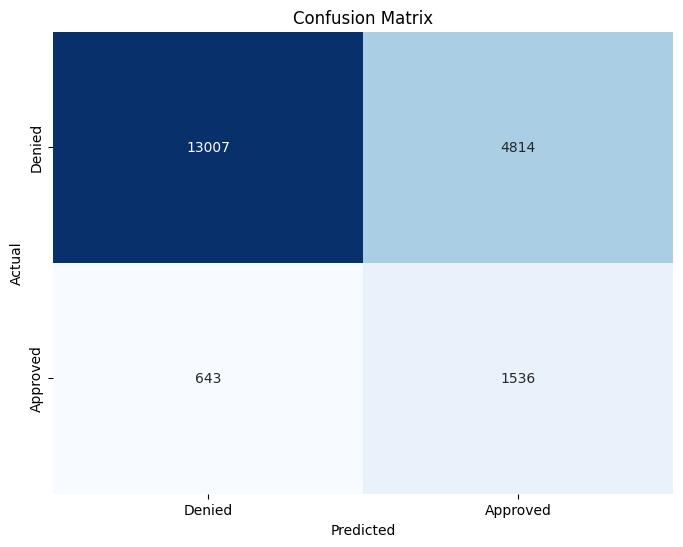

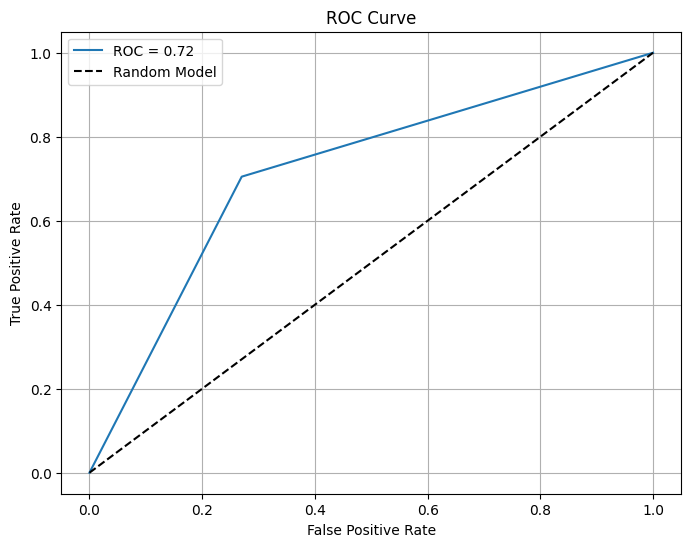

In [82]:
# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_log))
cm_log = confusion_matrix(y_test, y_test_log)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# ROC Curve
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_log)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

### 3.2 Decision Tree Classifier Model

Build and interpret a Decision Tree Classifier Model to predict the likelihood of loan approval (Approved = 1).



**Question**
How does the Decision Tree’s accuracy and AUC compare to the Logistic Regression model?

**Answer**
The Decision Tree's accuracy of 69.77% is lower than the Logistic Regression model's of 72.70%, indicating that Logistic Regression is better at correctly predicting loan approvals and denials. Additionally, the Decision Tree's AUC of 70.55% is slightly less than the Logistic Regression's AUC of71.75%, indicating that the Logistic Regression is better at distinguishing approved from denied compared to a random model.


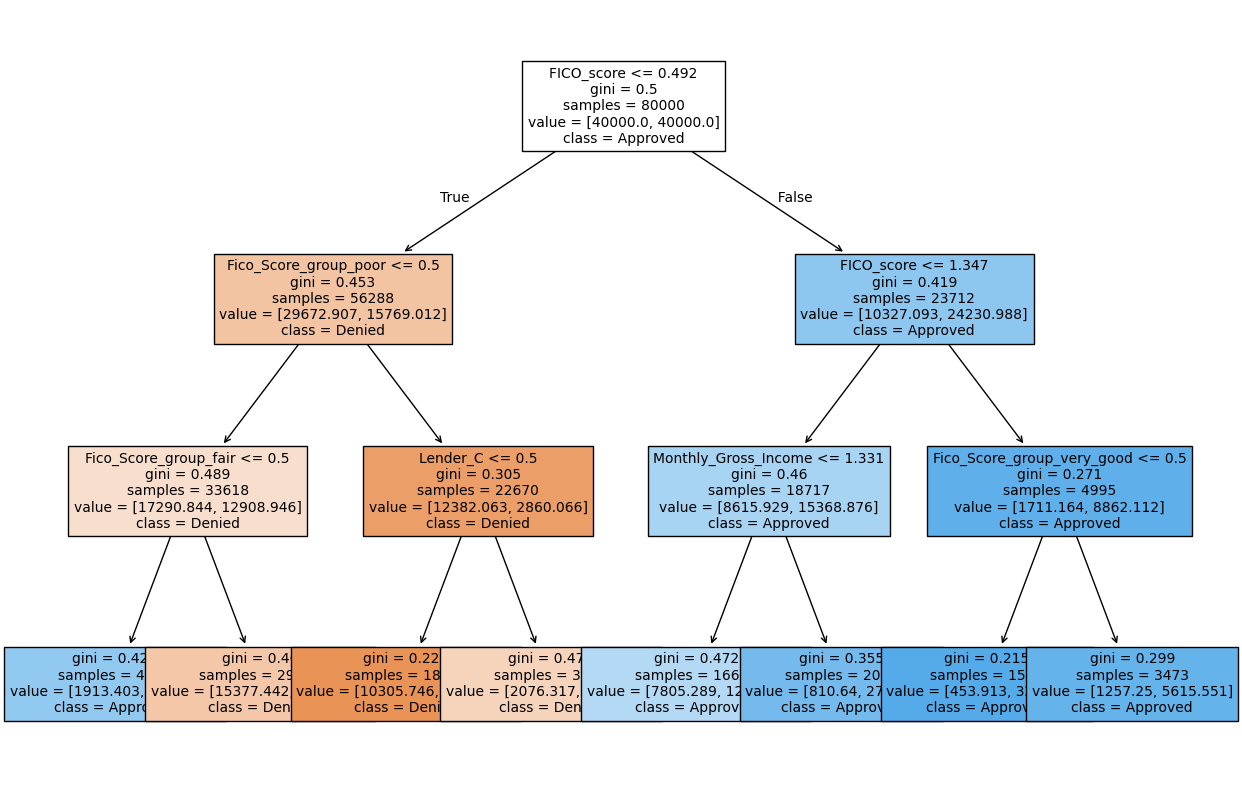

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Encode data for Decision Tree Model (Scaling not necessary)
X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)

# Train Decision Tree Model
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=3)
tree.fit(X_train, y_train)

#Plot Decision Tree Model
plt.figure(figsize=(15,10))
plot_tree(
    tree,
    feature_names=X_train.columns,
    class_names=['Denied', 'Approved'],
    filled=True,
    fontsize=10)
plt.show()


In [84]:
# Evaluate the model
y_train_tree = tree.predict(X_train)
y_test_tree = tree.predict(X_test)

# Classification Report, Accuracy, & ROC-AUC
print("Train Accuracy:", accuracy_score(y_train, y_train_tree))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_test_tree))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_tree))
print(classification_report(y_test, y_test_tree))


Train Accuracy: 0.696125
Decision Tree Accuracy: 0.6977
Test ROC-AUC: 0.7054967790834348
              precision    recall  f1-score   support

           0       0.95      0.70      0.80     17821
           1       0.22      0.72      0.34      2179

    accuracy                           0.70     20000
   macro avg       0.59      0.71      0.57     20000
weighted avg       0.87      0.70      0.75     20000



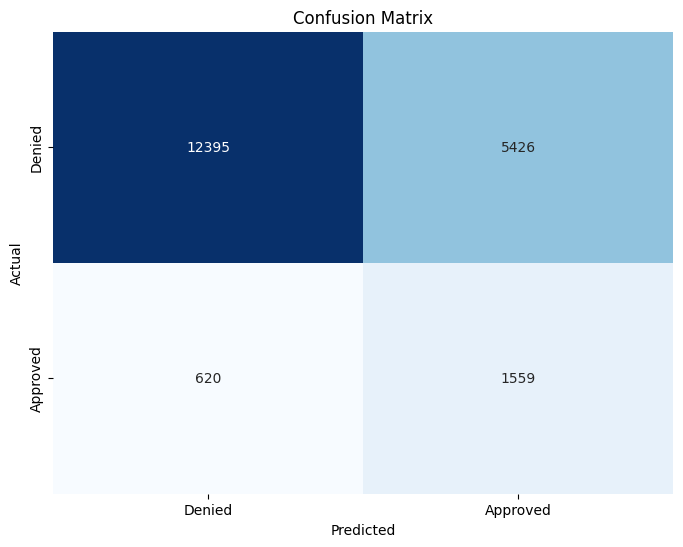

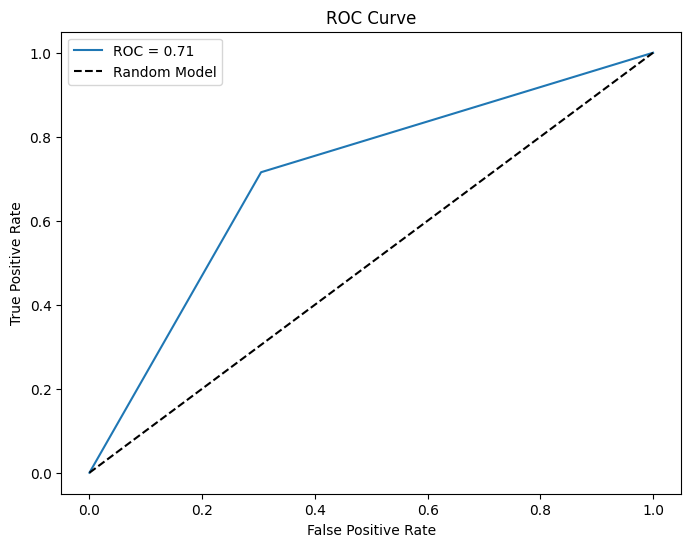

In [85]:
#Confusion Matrix for Decision Tree Model
cm_tree = confusion_matrix(y_test, y_test_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate ROC Curve for Decision Tree Model
fpr, tpr, thresholds = roc_curve(y_test, y_test_tree)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve for Decision Tree Model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()



In [86]:
# Variable importance for Decision Tree
importances = tree.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Print top features
print("Top 10 Features by Importance:")
print(feature_importance_df.head(10))

Top 10 Features by Importance:
                       Feature  Importance
1                   FICO_score    0.661796
12       Fico_Score_group_poor    0.140294
10       Fico_Score_group_fair    0.132364
28                    Lender_C    0.047114
2         Monthly_Gross_Income    0.016328
13  Fico_Score_group_very_good    0.002104
0        Requested_Loan_Amount    0.000000
4   Ever_Bankrupt_or_Foreclose    0.000000
7      Reason_home_improvement    0.000000
6     Reason_debt_conslidation    0.000000


                 Model  Accuracy   ROC-AUC  Precision    Recall  F1-Score
0        Decision Tree   0.69770  0.705497   0.223193  0.715466  0.340244
1  Logistic Regression   0.72715  0.717390   0.241890  0.704911  0.360183




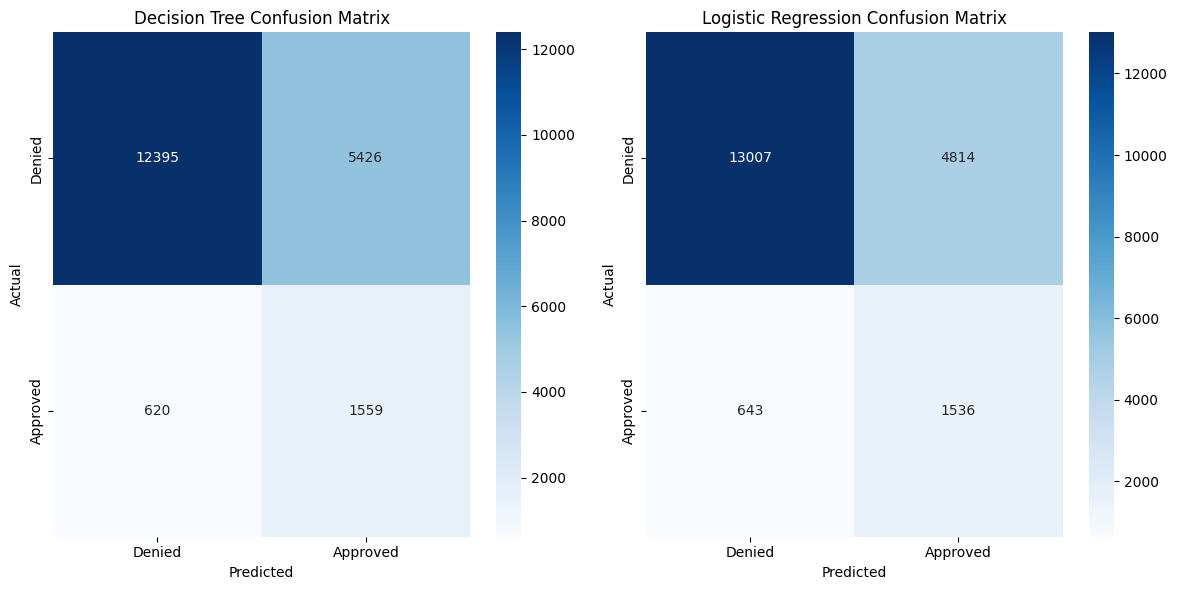

In [87]:
# Summary table of the KPIs for each model

# Pull KPIs for Decision Tree
tree_accuracy = accuracy_score(y_test, y_test_tree)
tree_roc_auc = roc_auc_score(y_test, y_test_tree)
tree_precision = precision_score(y_test, y_test_tree)
tree_recall = recall_score(y_test, y_test_tree)
tree_f1 = f1_score(y_test, y_test_tree)

# Pull KPIs for Logistic Regression
log_accuracy = accuracy_score(y_test, y_test_log)
log_roc_auc = roc_auc_score(y_test, y_test_log)
log_precision = precision_score(y_test, y_test_log)
log_recall = recall_score(y_test, y_test_log)
log_f1 = f1_score(y_test, y_test_log)

# Organize KPIs
model_compare = {
    'Model': ['Decision Tree', 'Logistic Regression'],
    'Accuracy': [tree_accuracy, log_accuracy],
    'ROC-AUC': [tree_roc_auc, log_roc_auc],
    'Precision': [tree_precision, log_precision],
    'Recall': [tree_recall, log_recall],
    'F1-Score': [tree_f1, log_f1]
}

# Model comparison DataFrame
model_compare_df = pd.DataFrame(model_compare)

# Display the DataFrame
print(model_compare_df)

print()
print()
# Compare Confusion Matrices
# Logistic Heatmap
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'], ax=axes[0])
axes[0].set_title('Decision Tree Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Decision Tree Heatmap
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'], ax=axes[1])
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()



## Compare the performance of the Logistic Regression and Decision Tree models.


1.   Compare the performance of the Logistic Regression and Decision Tree
models.
2.   Evaluate and compare both models using key metrics such as ROC-AUC, Accuracy, Precision, Recall, and F1-score.
3. Plot and interpret the confusion matrices for both models. Discuss what false positives and false negatives mean in the business context (for example, approving risky applicants vs. rejecting qualified ones).
4. Identify which model best captures the target event (loan approval) and explain why.
5. Justify your model choice from both technical (performance, interpretability) and business (actionability, trust, and decision-making) perspectives.
6. Indicate the cutoff threshold you used and why it makes sense for this scenario.




##Comparison
The Logistic Regression model captures loan approval best. Technically, it consistently performs slightly better at minimizing risky loan approvals, using a threshold of 0.5 to ensure accuracy. Logistic Regression is also interpretable, allowing banks and analysts to clearly understand the most influential factors impacting loan approvals.

From a business perspective, Logistic Regression aligns well with the bank's priorities of reducing risky loan approvals while still maintaining the approval of good applicants. Due to its interpretable and consistent performance, the model's recommendations can be trusted to enable strategic decision-making.

In [106]:
model = logmodel



In [108]:
# Save your model as .pkl file for streamlit app development
import pickle

filename = 'loanmodel.pkl'  # Choose a path and descriptive filename with .pkl extension

# Open the file in binary write mode ('wb')
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved successfully to {filename}")


Model saved successfully to loanmodel.pkl


In [88]:
coefs = logmodel.coef_[0]


features_coefs = pd.Series(coefs, index=X_train.columns)

# Filter to only numeric variables (assuming your numeric variables are float/int types in X_train)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Keep only numeric features
numeric_features_coefs = features_coefs[numeric_features]

# Print numeric features with their coefficients
print(numeric_features_coefs)


Requested_Loan_Amount        -0.185599
FICO_score                    0.175117
Monthly_Gross_Income          0.100929
Monthly_Housing_Payment      -0.014941
Ever_Bankrupt_or_Foreclose   -1.204979
dtype: float64


##Streamlit Deployment 📱

###Step 1: Install All Libraries

In [74]:
!pip install streamlit pandas scikit-learn -q
!npm install localtunnel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.5 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 3s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧npm notice
npm notice New major version of npm available! 10.8.2 -> 11.6.4
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.6.4
npm notice To update run: npm install -g npm@11.6.4
npm notice
⠧

###Step 2: Write Your App Code (app.py)

In [115]:
%%writefile loanmodelapp.py

import streamlit as st
import pickle
import pandas as pd
import sklearn



# load trained model
with open("loanmodel.pkl", "rb") as file:
    model = pickle.load(file)


# App title
st.markdown(
    "<h1 style='text-align: center; background-color: #ffcccc; padding: 10px; color: #cc0000;'><b>Loan Approval</b></h1>",
    unsafe_allow_html=True
)

# Numeric inputs
st.header("Enter Loan Applicant's Details")

# Input fields for numeric values #order way they were entered in the model
Requested_Loan_Amount = st.slider('Requested Loan Amount', min_value=1000, max_value=500000, step=1000)
FICO_score = st.slider('FICO Score', min_value=300, max_value=850, step=1)
Monthly_Gross_Income = st.slider('Monthly Gross Income', min_value=500, max_value=20000, step=100)
Monthly_Housing_Payment = st.slider('Monthly Housing Payment', min_value=500, max_value=20000, step=100)
Ever_Bankrupt_or_Foreclose = st.selectbox('Ever Bankrupt or Foreclosed', ['Yes', 'No'])

# Categorical Inputs with options
Reason = st.selectbox('Reason', ['Debt Consolidation', 'Home Improvement', 'Unexpected Cost', 'Major Purchase',
                                 'Credit Card Refinancing', 'Other'])
Employment_Status = st.selectbox('Employment Status', ['Full Time', 'Part Time', 'Unemployed'])



# --- Prepare Data for Prediction ---
input_data = pd.DataFrame([{
    'Requested_Loan_Amount': Requested_Loan_Amount,
    'FICO_score': FICO_score,
    'Monthly_Gross_Income': Monthly_Gross_Income,
    'Monthly_Housing_Payment': Monthly_Housing_Payment,
    'Ever_Bankrupt_or_Foreclose': Ever_Bankrupt_or_Foreclose,
    'Reason': Reason,
    'Employment_Status': Employment_Status
}])

# Convert Yes/No to numeric
input_data['Ever_Bankrupt_or_Foreclose'] = input_data['Ever_Bankrupt_or_Foreclose'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical columns
input_data_encoded = pd.get_dummies(input_data, columns=['Reason', 'Employment_Status'])

# Add missing columns expected by the model
for col in model.feature_names_in_:
    if col not in input_data_encoded.columns:
        input_data_encoded[col] = 0

# Reorder columns to match model
input_data_encoded = input_data_encoded[model.feature_names_in_]

# Predict button
if st.button("Evaluate Loan"):
    prediction = model.predict(input_data_encoded)[0]
    if prediction == 1:
        st.write("The prediction is: **Loan Approved** 💲")
    else:
        st.write("The prediction is: **Loan Denied** 🚫")

Overwriting loanmodelapp.py


###Step 3: Write Your Requirements File

In [110]:
%%writefile requirements.txt
streamlit
pandas
scikit-learn
numpy

Writing requirements.txt


###Step 4: Test Your App Live!

In [100]:
# Run the app in the background
!streamlit run loan_log_modelapp.py &>/dev/null&

# Get the password (your IP) and print it.
# The "&" runs it in the background while the tunnel starts.
print("Fetching your tunnel password...")
!curl https://loca.lt/mytunnelpassword &

# Start the tunnel. This command will keep the cell running and give you the URL.
!npx localtunnel --port 8501

Fetching your tunnel password...
34.26.74.26⠙your url is: https://stupid-tables-take.loca.lt
^C


added note: get .pi, pkl, & requirements about text, put in github, put github in streamlit

**Question:**
Which model do you recommend and why? (Provide both technical and business reasoning.)

**Answer:** We recommend the Logistic Regression Model because the 0.5 threshold enables an accurate and careful model that prevents the approval of risky loans. This ensures the banks utilizing these models minimize the risk of financial loss. Logistic Regression models are also easily interpretable, which is essential when implementing into business operations because it drives consistent and strategic decision-making across the entire organization.

## 5. Recommendations
In this final section, summarize your key findings and provide concise business recommendations based on your analysis.


**Write a short paragraph including:**  
- A brief summary of your main findings from the analysis and model comparison.  
- The key factors that most influence loan approval.  
- Your recommendations on data or model based on the results  (for example, how approval decisions could be improved or better understood).  
- One next step you would take to improve the model or extend the analysis further.  


**Add your paragraph here:** Our analysis and model comparison revealed that both the Decision Tree and Logistic Regression models performed similarly in predicting loan approvals, with the Logistic model consistently reaching slightly higher accuracy. Some of the key factors influencing loan approval are FICO score, monthly gross income, monthly housing payment, prior bankruptcy or foreclosure, reason for the loan, and employment status. By applying a conservative 0.5 threshold, the Logistic Regression model minimizes the risk of approving risky loans. Based on our analysis of the models, we recommend the Logistic Regression due to its consistency and enhanced risk mitigation. A next step would be to explore additional financial and behavioral features, like recent late payments, debt-to-income ratio, and years at current job to improve the model's accuracy and better understand approval decisions.



---



**Question:**  What trade-offs or risks should the company be aware of when using this model?  

**Answer:** The company should note that our model uses a conservative 0.5 threshold. This is important to consider because although it minimizes the risk of financial losses from approving risky loans, it also risks denying loans to worthy applicants.

**Question:** How confident are you in your model’s generalizability — what might change its performance in real-world use?   

**Answer:** we are fairly confident in our model's generalizability due to the similar performance on both training and test data. The data, however, is imbalanced with more data for denied loans, which may challenge its performance in the real-world.


**Question:** If you had access to additional data, what new feature would you collect to strengthen this model?

**Answer:** Features that help better predict an individual's financial stability, like years at current job and own Vs. rent.